# Channels covariance

In this notebook we compute the covariance between channels for the different models when using root scaling. The goal is to recreate some of the viz in notebook 1 for the VT paper

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from torch.utils.data import DataLoader
import torch
from torchsummary import summary

from scipy.ndimage import uniform_filter, convolve
from scipy.stats import levene

from sdo.datasets.sdo_dataset import SDO_Dataset
from sdo.datasets.virtual_telescope_sdo_dataset import VirtualTelescopeSDO_Dataset
from sdo.models.vt_models.vt_unet import VT_UnetGenerator
from sdo.metrics.covariance import time_covariance, cov_1d, neighbor_cov

In [4]:
results_path = '/fdl_sdo_data/bucket2/EXPERIMENT_RESULTS/VIRTUAL_TELESCOPE/'
filename_211 = results_path + 'vale_exp_23/0600_vale_exp_23_test_predictions_timestamps.npz'
filename_193 = results_path + 'vale_exp_25/0600_vale_exp_25_test_predictions_timestamps.npz'
filename_171 = results_path + 'vale_exp_26/0600_vale_exp_26_test_predictions_timestamps.npz'
filename_94 = results_path + 'vale_exp_27/0400_vale_exp_27_test_predictions_timestamps.npz'

In [5]:
def list_dates(pred_path):
    pred = np.load(pred_path)
    timestamps = pred['ts']
    return timestamps

def find_date_index(date, data):
    for index, item in enumerate(data['ts']):
        if all(item == date):
            return index
    print(f'The date {date} has not been found')
    return None
        
def load_timestamped_img(pred_path, dates, img='img'):
    pred = np.load(pred_path)
    indexes = [find_date_index(date, pred) for date in dates]
    if None not in indexes:
        return pred[img][indexes]
    else:
        print(f'None is not a valid index, img cannot be loaded')

def cov_channels_on_time(pred_path_ch1, pred_path_ch2, dates, img='img'):
    ch1_img = load_timestamped_img(pred_path_ch1, dates, img)
    ch2_img = load_timestamped_img(pred_path_ch2, dates, img)
    return time_covariance(ch1_img, ch2_img)

In [6]:
timestamps211 = list_dates(filename_211)

In [14]:
timestamps211[:20]

array([[2011,    8,   23,   12,    0],
       [2012,    8,   19,   12,    0],
       [2012,    8,    9,   18,    0],
       [2011,    9,   30,   12,    0],
       [2011,    9,   14,   12,    0],
       [2011,    9,    5,   18,    0],
       [2012,   10,   23,   12,    0],
       [2011,    8,   16,   18,    0],
       [2011,    9,   22,    0,    0],
       [2012,    9,   28,    6,    0],
       [2011,   10,    2,   12,    0],
       [2012,    9,   15,    0,    0],
       [2011,    9,    9,   12,    0],
       [2012,    9,    7,   18,    0],
       [2011,    8,   11,    0,    0],
       [2012,    9,   14,    0,    0],
       [2011,    8,   27,   18,    0],
       [2011,   10,    9,    0,    0],
       [2011,    9,    1,   12,    0],
       [2012,    8,   15,    0,    0]])

# Covariance between channels on Valentine's Day Flare

In [7]:
flare_date = [2011, 2, 15, 1, 50]
datetime_range = [['2011-02-15 00:00:00', '2011-02-15 04:00:00']]
flare_data = VirtualTelescopeSDO_Dataset(data_basedir='/fdl_sdo_data/SDOMLmm/fdl_sw/SDOMLmm', 
    data_inventory='/home/Valentina/inventory_1904.pkl', 
    instr=["AIA", "AIA", "AIA", "AIA"], 
    num_channels = 4,
    channels=["0094", "0193", "0171", "0211"],
    datetime_range = datetime_range,
    resolution=512,
    subsample=1,
    test=False,
    test_ratio=0.0,
    shuffle=False,
    normalization=0,
    scaling=True,
    apodize=False,
    holdout=False)

/home/Valentina/expanding-sdo-capabilities/src/sdo/datasets/dates_selection.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sel_df['date'] = sel_df.apply(from_row_to_date, axis=1)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6701: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [8]:
#for idx, (_, _,timestamp) in enumerate(flare_data):
#    print(idx, timestamp)
    
# the above selects timestamps at interval of 6 minutes (0,6,12, 18 etc.)
sel_timestamps = [
    [2011,    2,   15,   0,    0],
    [2011,    2,   15,   1,    0],
    [2011,    2,   15,   2,    0],
    [2011,    2,   15,   3,    0],
    [2011,    2,   15,   4,    0],
]

sel_index = []
for idx, (_, _,timestamp) in enumerate(flare_data):
    if timestamp.numpy().tolist() in sel_timestamps:
        sel_index.append(idx)
        
# sel_index = [0, 10, 20, 30, 40]

In [9]:
# we collect the data for the analysis
input_data = []
gt_img = []
timestamps = []
for idx in sel_index:
    input_data.append(flare_data[idx][0]) 
    gt_img.append(flare_data[idx][1])
    timestamps.append(flare_data[idx][2])

In [10]:
# load the trained model for inference (it takes a couple of mins)
# to use the root model root_scaling needs to be removed
model_path = results_path + 'vale_exp_20/0600_vale_exp_20_model.pth'
model = VT_UnetGenerator(input_shape=[3, 512, 512])
state_dict = torch.load(model_path)
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace("module.", "") 
    new_state_dict[name] = v
model.load_state_dict(new_state_dict)
model.eval();

In [11]:
# compute the virtual image for each timestamp (this will take several minutes)
outputs = []
for i, idx in enumerate(sel_index):
    print(flare_data[idx][2])
    output = model(flare_data[idx][0].unsqueeze(0)).detach().numpy().reshape(1, 512, 512)
    outputs.append(output)

tensor([2011,    2,   15,    0,    0])
tensor([2011,    2,   15,    1,    0])
tensor([2011,    2,   15,    2,    0])
tensor([2011,    2,   15,    3,    0])
tensor([2011,    2,   15,    4,    0])


# Looking at difference in covariance at interval of 1h

In [12]:
results = pd.DataFrame()
for i, idx in enumerate(sel_index):
    ts = '-'.join([str(i.item()) for i in timestamps[i]])
    X_s = outputs[i].reshape(512, 512)
    X_orig = gt_img[i].detach().numpy().reshape(512, 512)
    for j, ch in enumerate(["094", "193", "171"]):
        cov_orig, cov_synth = 0, 0
        Y = input_data[i][j].detach().numpy().reshape(512, 512)
        cov_orig = cov_1d(X_orig,Y)
        cov_synth = cov_1d(X_s,Y)
        results = results.append(
            pd.DataFrame(index=[i], data={'Timestamp': ts, 'Channel': ch, 
                               'True Cov': round(cov_orig, 3), 'Pred Cov': round(cov_synth, 3), 
                               'Diff': round((cov_orig - cov_synth), 3), 
                               '%Diff': round((cov_orig - cov_synth)*100/cov_orig, 1)})
        )

In [13]:
results.reset_index().drop('index', axis=1).sort_values('Channel').style.background_gradient(cmap='YlOrRd')

,Timestamp,Channel,True Cov,Pred Cov,Diff,%Diff
0,2011-2-15-0-0,094,0.278,0.256,0.022,7.9
3,2011-2-15-1-0,094,0.262,0.246,0.016,5.9
6,2011-2-15-2-0,094,13.874,92.346,-78.472,-565.6
9,2011-2-15-3-0,094,1.691,1.54,0.15,8.9
12,2011-2-15-4-0,094,0.392,0.375,0.017,4.4
2,2011-2-15-0-0,171,0.117,0.115,0.002,2.1
5,2011-2-15-1-0,171,0.114,0.112,0.002,1.9
8,2011-2-15-2-0,171,1.29,13.076,-11.786,-913.6
11,2011-2-15-3-0,171,0.186,0.178,0.008,4.3
14,2011-2-15-4-0,171,0.139,0.136,0.003,2.3


In [14]:
print(results.sort_values('Channel').to_latex(index=False))

\begin{tabular}{llrrrr}
\toprule
     Timestamp & Channel &  True Cov &  Pred Cov &    Diff &  \%Diff \\
\midrule
 2011-2-15-0-0 &     094 &     0.278 &     0.256 &   0.022 &    7.9 \\
 2011-2-15-1-0 &     094 &     0.262 &     0.246 &   0.016 &    5.9 \\
 2011-2-15-2-0 &     094 &    13.874 &    92.346 & -78.472 & -565.6 \\
 2011-2-15-3-0 &     094 &     1.691 &     1.540 &   0.150 &    8.9 \\
 2011-2-15-4-0 &     094 &     0.392 &     0.375 &   0.017 &    4.4 \\
 2011-2-15-0-0 &     171 &     0.117 &     0.115 &   0.002 &    2.1 \\
 2011-2-15-1-0 &     171 &     0.114 &     0.112 &   0.002 &    1.9 \\
 2011-2-15-2-0 &     171 &     1.290 &    13.076 & -11.786 & -913.6 \\
 2011-2-15-3-0 &     171 &     0.186 &     0.178 &   0.008 &    4.3 \\
 2011-2-15-4-0 &     171 &     0.139 &     0.136 &   0.003 &    2.3 \\
 2011-2-15-0-0 &     193 &     0.048 &     0.047 &   0.001 &    1.4 \\
 2011-2-15-1-0 &     193 &     0.047 &     0.047 &   0.001 &    1.3 \\
 2011-2-15-2-0 &     193 &     0.1

* As expected results are very different for 193/171 and 094, being in general much worse for 094
* Difference between real and predicted covariance >1h before the flare is ~1%, but can arrive up to 6% in 094
* After and close to the flare the predicted covariance is completely off and systematically larger

In [15]:
datetime_range = [['2011-02-13 00:00:00', '2011-02-13 04:00:00']]
non_flare_data = VirtualTelescopeSDO_Dataset(data_basedir='/fdl_sdo_data/SDOMLmm/fdl_sw/SDOMLmm', 
    data_inventory='/home/Valentina/inventory_1904.pkl', 
    instr=["AIA", "AIA", "AIA", "AIA"], 
    num_channels = 4,
    channels=["0094", "0193", "0171", "0211"],
    datetime_range = datetime_range,
    resolution=512,
    subsample=1,
    test=False,
    test_ratio=0.0,
    shuffle=False,
    normalization=0,
    scaling=True,
    apodize=False,
    holdout=False)
sel_index = [0, 10, 20, 30, 40]

/home/Valentina/expanding-sdo-capabilities/src/sdo/datasets/dates_selection.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sel_df['date'] = sel_df.apply(from_row_to_date, axis=1)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6701: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [16]:
# we collect the data for the analysis
nf_input_data = []
nf_gt_img = []
nf_timestamps = []
for idx in sel_index:
    nf_input_data.append(non_flare_data[idx][0]) 
    nf_gt_img.append(non_flare_data[idx][1])
    nf_timestamps.append(non_flare_data[idx][2])

In [17]:
# compute the virtual image for each timestamp (this will take several minutes)
nf_outputs = []
for i, idx in enumerate(sel_index):
    print(non_flare_data[idx][2])
    nf_output = model(non_flare_data[idx][0].unsqueeze(0)).detach().numpy().reshape(1, 512, 512)
    nf_outputs.append(nf_output)

tensor([2011,    2,   13,    0,    0])
tensor([2011,    2,   13,    1,    0])
tensor([2011,    2,   13,    2,    0])
tensor([2011,    2,   13,    3,    0])
tensor([2011,    2,   13,    4,    0])


In [40]:
def compute_cov_df(timestamps, outputs, gt_img, input_data):
    results = pd.DataFrame()
    for i, idx in enumerate(sel_index):
        ts = '-'.join([str(i.item()) for i in timestamps[i]])
        X_s = outputs[i].reshape(512, 512)
        X_orig = gt_img[i].detach().numpy().reshape(512, 512)
        for j, ch in enumerate(["094", "193", "171"]):
            cov_orig, cov_synth = 0, 0
            Y = input_data[i][j].detach().numpy().reshape(512, 512)
            cov_orig = cov_1d(X_orig,Y)
            cov_synth = cov_1d(X_s,Y)
            results = results.append(
                pd.DataFrame(index=[i], data={'Timestamp': ts, 'Channel': ch, 
                                   'True Cov': np.round(cov_orig, 4), 'Pred Cov': np.round(cov_synth, 4), 
                                   'Diff': np.round((cov_orig - cov_synth), 4), 
                                   '%Diff': np.round((cov_orig - cov_synth)*100/cov_orig, 1)})
            )
    return results

nf_results = compute_cov_df(nf_timestamps, nf_outputs, nf_gt_img, nf_input_data)

In [41]:
nf_results.reset_index().drop('index', axis=1).sort_values('Channel').style.background_gradient(cmap='YlOrRd')

,Timestamp,Channel,True Cov,Pred Cov,Diff,%Diff
0,2011-2-13-0-0,094,0.1506,0.1504,0.0002,0.1
3,2011-2-13-1-0,094,0.1672,0.1654,0.0018,1.1
6,2011-2-13-2-0,094,0.1601,0.1588,0.0013,0.8
9,2011-2-13-3-0,094,0.1713,0.1718,-0.0004,-0.3
12,2011-2-13-4-0,094,0.1652,0.165,0.0002,0.1
2,2011-2-13-0-0,171,0.1213,0.121,0.0002,0.2
5,2011-2-13-1-0,171,0.1261,0.1254,0.0007,0.5
8,2011-2-13-2-0,171,0.1227,0.1223,0.0004,0.3
11,2011-2-13-3-0,171,0.1241,0.1244,-0.0002,-0.2
14,2011-2-13-4-0,171,0.1226,0.1219,0.0007,0.6


In [42]:
print(nf_results.sort_values('Channel').to_latex(index=False))

\begin{tabular}{llrrrr}
\toprule
     Timestamp & Channel &  True Cov &  Pred Cov &    Diff &  \%Diff \\
\midrule
 2011-2-13-0-0 &     094 &    0.1506 &    0.1504 &  0.0002 &    0.1 \\
 2011-2-13-1-0 &     094 &    0.1672 &    0.1654 &  0.0018 &    1.1 \\
 2011-2-13-2-0 &     094 &    0.1601 &    0.1588 &  0.0013 &    0.8 \\
 2011-2-13-3-0 &     094 &    0.1713 &    0.1718 & -0.0004 &   -0.3 \\
 2011-2-13-4-0 &     094 &    0.1652 &    0.1650 &  0.0002 &    0.1 \\
 2011-2-13-0-0 &     171 &    0.1213 &    0.1210 &  0.0002 &    0.2 \\
 2011-2-13-1-0 &     171 &    0.1261 &    0.1254 &  0.0007 &    0.5 \\
 2011-2-13-2-0 &     171 &    0.1227 &    0.1223 &  0.0004 &    0.3 \\
 2011-2-13-3-0 &     171 &    0.1241 &    0.1244 & -0.0002 &   -0.2 \\
 2011-2-13-4-0 &     171 &    0.1226 &    0.1219 &  0.0007 &    0.6 \\
 2011-2-13-0-0 &     193 &    0.0449 &    0.0448 &  0.0000 &    0.1 \\
 2011-2-13-1-0 &     193 &    0.0470 &    0.0468 &  0.0002 &    0.4 \\
 2011-2-13-2-0 &     193 &    0.04

In [33]:
#summary(model, (3, 512, 512), branching=False);

# Comparing maps using a Neighborhood covariance with rolling average window

tensor([2011,    2,   15,    0,    0])


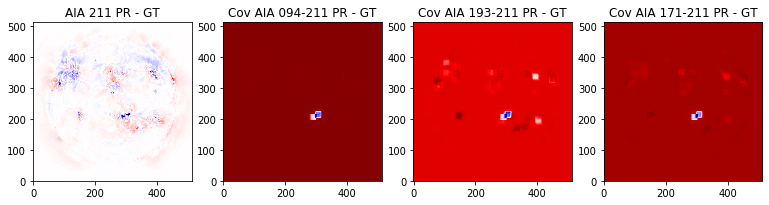

tensor([2011,    2,   15,    1,    0])


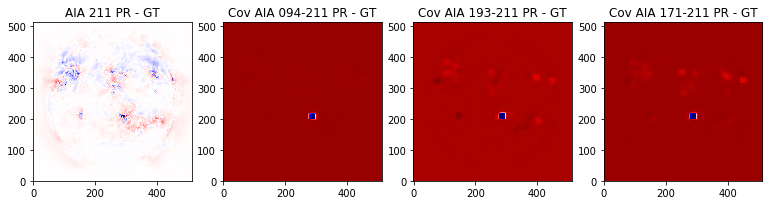

tensor([2011,    2,   15,    2,    0])


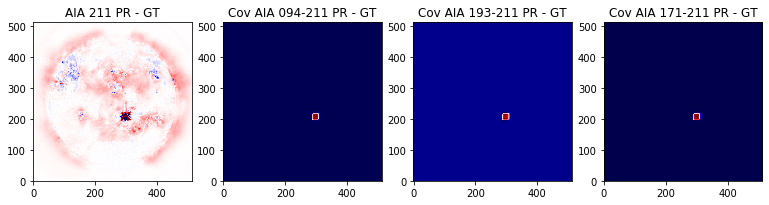

tensor([2011,    2,   15,    3,    0])


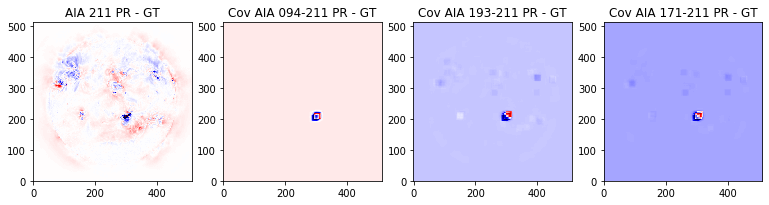

tensor([2011,    2,   15,    4,    0])


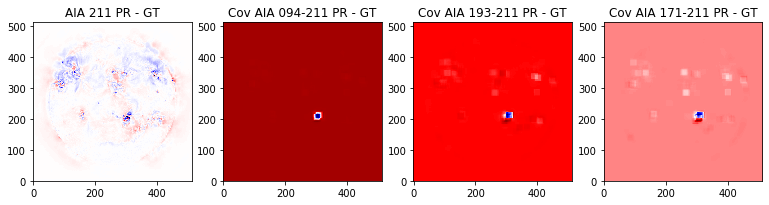

In [52]:
# compute covariance with real and synthetic image
for i, idx in enumerate(sel_index):
    fig, axs = plt.subplots(1,4, figsize=(15, 10))
    print(timestamps[i])
    X_s = outputs[i].reshape(512, 512)
    X_orig = gt_img[i].detach().numpy().reshape(512, 512)
    im = axs[0].set_title(f'AIA 211 PR - GT')
    im = axs[0].imshow((X_s - X_orig), cmap='seismic', origin='lower', vmin=-1.0, vmax=1.0)
    for j, ch in enumerate(["094", "193", "171"]):    
        Y = input_data[i][j].detach().numpy().reshape(512,512)
        cov_synth = neighbor_cov(X_s, Y, size=20)
        cov_orig = neighbor_cov(X_orig, Y, size=20)
        Z = cov_synth - cov_orig
        im = axs[j+1].set_title(f'Cov AIA {ch}-{211} PR - GT')
        im = axs[j+1].imshow(Z, cmap='seismic', origin='lower', vmin=Z.min(), vmax=Z.max())
        fig.subplots_adjust(bottom=0.1, right=0.8, top=0.8)
        #cbar_ax = fig.add_axes([0.85, 0.3, 0.03, 0.3])
        fig.colorbar(im, cax=cbar_ax)
    plt.show()

as suggested by the aggregated covariance on the full image, results before and after the flare are much worse, 
particulalry the 094-211 pair. We can however see the error is localised

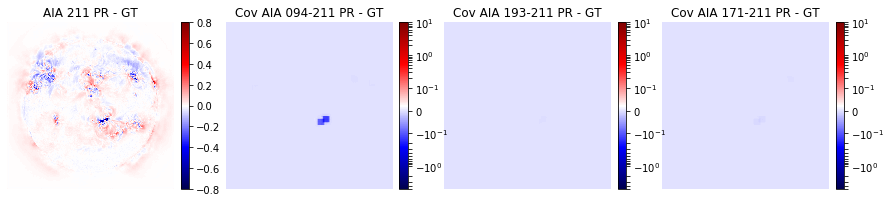

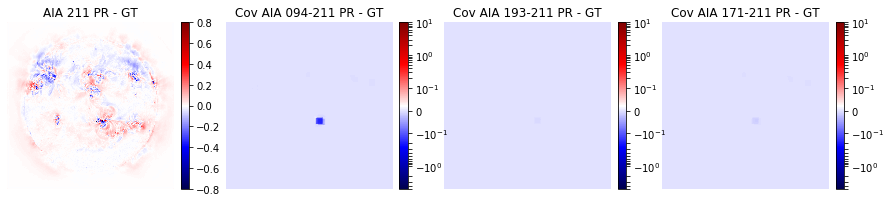

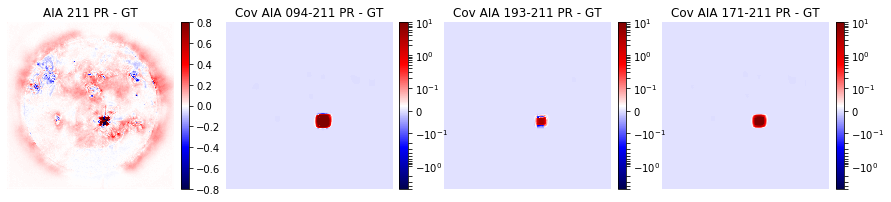

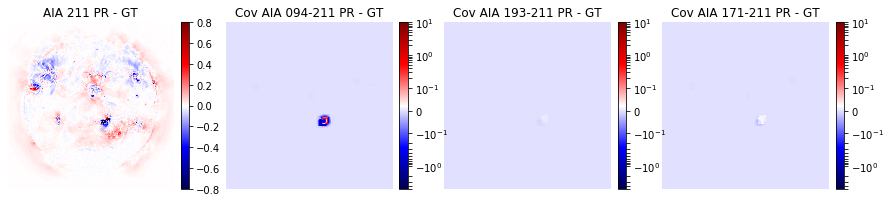

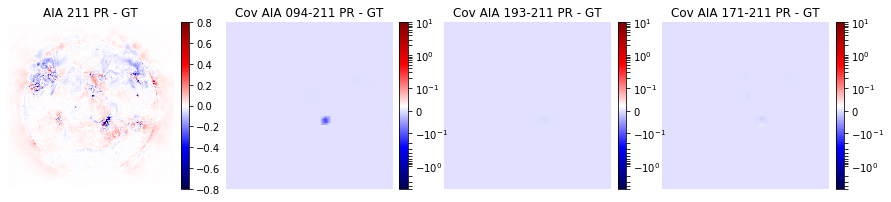

In [86]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
# same as above but with LogNorm, to show what happens close to the flare
for i, idx in enumerate([0, 10, 20, 30, 40]):
        fig, axs = plt.subplots(1,4, figsize=(15, 18))
        #print(timestamps[i])
        X_s = outputs[i].reshape(512, 512)
        X_orig = gt_img[i].detach().numpy().reshape(512, 512)
        im = axs[0].set_title(f'AIA 211 PR - GT')
        im = axs[0].imshow((X_s - X_orig), cmap='seismic', origin='lower', vmin=-0.8, vmax=0.8)
        axs[0].set_axis_off()
        divider = make_axes_locatable(axs[0])
        cax = divider.append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im, cax=cax)
        for j, ch in enumerate(["094", "193", "171"]):    
            Y = input_data[i][j].detach().numpy().reshape(512,512)
            cov_synth = neighbor_cov(X_s, Y, size=20)
            cov_orig = neighbor_cov(X_orig, Y, size=20)
            im = axs[j+1].set_title(f'Cov AIA {ch}-{211} PR - GT')
            Z = cov_synth - cov_orig
            im = axs[j+1].imshow(Z, cmap='seismic', origin='lower',
                                norm=mpl.colors.SymLogNorm(linthresh=0.1, vmin=-5, vmax=10))
            axs[j+1].set_axis_off()
            #fig.subplots_adjust(bottom=0.1, right=0.8, top=0.8)
            divider = make_axes_locatable(axs[j+1])
            cax = divider.append_axes('right', size='5%', pad=0.1)
            #cbar_ax = fig.add_axes([0.85, 0.3, 0.03, 0.3])
            fig.colorbar(im, cax=cax)
        #plt.show()
        filename = '/home/Valentina/results/plots' + f'211_covariance_{idx}.pdf'
        fig.savefig(filename, tight_layout=True)

In [54]:
timestamps

[tensor([2011,    2,   15,    0,    0]),
 tensor([2011,    2,   15,    1,    0]),
 tensor([2011,    2,   15,    2,    0]),
 tensor([2011,    2,   15,    3,    0]),
 tensor([2011,    2,   15,    4,    0])]